In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data=pd.read_excel('rumor_s.xlsx')

In [3]:
data.head()

,Unnamed: 0,title,text,label
0,23501,u budget fight loom republican flip fiscal script,washington reuters head conservative republica...,0
1,23502,u military accept transgender recruit monday p...,washington reuters transgender people allowed ...,0
2,23503,senior u republican senator let mr mueller job,washington reuters special counsel investigati...,0
3,23504,fbi russia probe helped australian diplomat ti...,washington reuters trump campaign adviser geor...,0
4,23505,trump want postal service charge much amazon s...,seattle washington reuters president donald tr...,0


In [4]:
# drop the unwanted columns

to_drop=["Unnamed: 0",'title']
data=data.drop(data[to_drop],axis=1)

In [5]:
data.label.value_counts()

0    21417
1    21417
Name: label, dtype: int64

In [6]:
#dropping null rows
data=data.dropna()

In [7]:
 # split the dataset
    
train,test=train_test_split(data,random_state=42,test_size=0.2)

#check the shape of data

train.shape,test.shape

((33812, 2), (8453, 2))

In [8]:
# Tokenize the text inputs 

text_tokenizer = Tokenizer(num_words=10000)
text_tokenizer.fit_on_texts(train['text'].values)

In [9]:
# Convert text  input to sequences

train_text_seq = text_tokenizer.texts_to_sequences(train['text'].values)

In [10]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
    
tokenizer = Tokenizer(num_words=1000)
with open('tokenizers.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle,protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
# Apply padding to make the sequences of equal length

max_length_text = 200

train_text = pad_sequences(train_text_seq, maxlen=max_length_text)

In [13]:
# Load pre-trained GloVe word embeddings

embeddings_index = {}
with open('glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [14]:
# Create embedding matrices for text input

embedding_dim = 300
text_word_index = text_tokenizer.word_index
num_words_text = min(10000, len(text_word_index) + 1)
text_embedding_matrix = np.zeros((num_words_text, embedding_dim))
for word, i in text_word_index.items():
    if i >= num_words_text:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        text_embedding_matrix[i] = embedding_vector

In [15]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout

In [16]:
model = Sequential()

# Add the embedding layer

model.add(Embedding(num_words_text, embedding_dim, 
                    weights=[text_embedding_matrix], 
                    input_length=max_length_text, 
                    trainable=False))

# Add convolutional layers

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())

# Add fully connected layers

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile the model

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

In [17]:
# Define early stopping criteria

early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [18]:
# Train the model

history = model.fit(train_text, train['label'], epochs=2, batch_size=128, validation_split=0.2)


Epoch 1/2
212/212 [==============================] - 60s 259ms/step - loss: 0.0883 - accuracy: 0.9652 - val_loss: 0.0276 - val_accuracy: 0.9910
Epoch 2/2
212/212 [==============================] - 56s 264ms/step - loss: 0.0150 - accuracy: 0.9957 - val_loss: 0.0236 - val_accuracy: 0.9926


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 300)          3000000   
                                                                 
 conv1d (Conv1D)             (None, 198, 128)          115328    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [20]:
# Save the model to a file

model.save('CNN_model.h5')

In [19]:
#load the saved model
from tensorflow.keras.models import load_model


model = load_model('CNN_model.h5')

In [20]:
# Evaluate the model on the test data
test_text_seq = text_tokenizer.texts_to_sequences(test['text'].values)
test_text = pad_sequences(test_text_seq, maxlen=max_length_text)
test_loss, test_acc = model.evaluate(test_text, test['label'])
print('Test accuracy:', test_acc)

265/265 [==============================] - 30s 38ms/step - loss: 0.0205 - accuracy: 0.9936
Test accuracy: 0.993611752986908


In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [22]:
# Predict labels for the validation set
y_pred = model.predict([test_text])

# Convert predicted probabilities to binary labels
y_pred = np.round(y_pred)

# Print the classification report
print(classification_report(test['label'], y_pred))

265/265 [==============================] - 9s 34ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4285
           1       1.00      0.99      0.99      4168

    accuracy                           0.99      8453
   macro avg       0.99      0.99      0.99      8453
weighted avg       0.99      0.99      0.99      8453



In [23]:
test_text_seq = text_tokenizer.texts_to_sequences(test['text'].values)

# Apply padding to make the sequences of equal length
test_text = pad_sequences(test_text_seq, maxlen=max_length_text)


# Predict on test data
predictions = model.predict([test_text])

predicted_labels = [1 if val > 0.5 else 0 for val in predictions]
print(predicted_labels)

265/265 [==============================] - 10s 37ms/step
[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 

In [24]:
# Define y_test

y_test = test['label'].values

y_pred = model.predict([test_text])
y_pred = [1 if val > 0.5 else 0 for val in y_pred]
cm = confusion_matrix(y_test, y_pred)
print(cm)

265/265 [==============================] - 10s 36ms/step
[[4265   20]
 [  34 4134]]


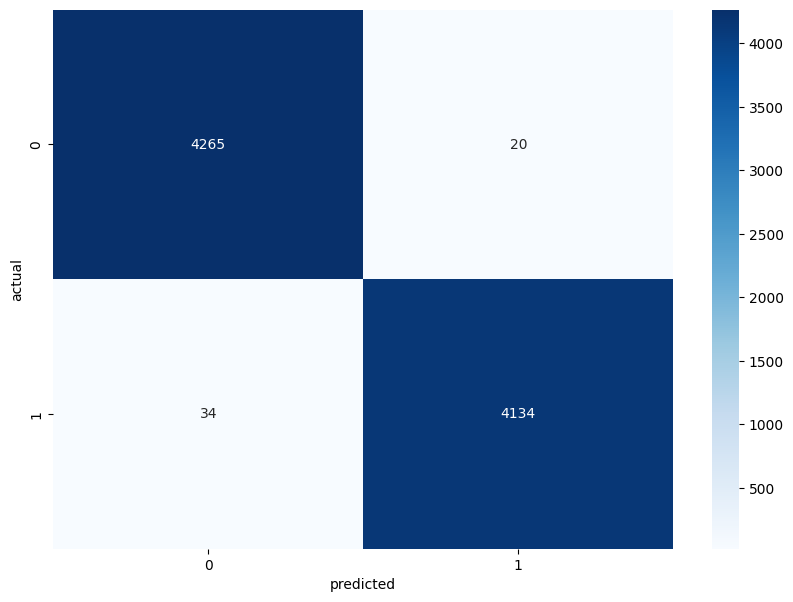

In [29]:
#the heat map
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True,fmt='g',cmap='Blues')
plt.ylabel("actual")
plt.xlabel('predicted');

In [30]:
# Make predictions on new text data
new_text = ["The number of cases of cops brutalizing and killing people of color seems to see no end. Now, we have another case that needs to be shared far and wide. An Alabama woman by the name of Angela Williams shared a graphic photo of her son, lying in a hospital bed with a beaten and fractured face, on Facebook. It needs to be shared far and wide, because this is unacceptable.It is unclear why Williams  son was in police custody or what sort of altercation resulted in his arrest, but when you see the photo you will realize that these details matter not. Cops are not supposed to beat and brutalize those in their custody. In the post you are about to see, Ms. Williams expresses her hope that the cops had their body cameras on while they were beating her son, but I think we all know that there will be some kind of convenient  malfunction  to explain away the lack of existence of dash or body camera footage of what was clearly a brutal beating. Hell, it could even be described as attempted murder. Something tells me that this young man will never be the same. Without further ado, here is what Troy, Alabama s finest decided was appropriate treatment of Angela Williams  son:No matter what the perceived crime of this young man might be, this is completely unacceptable. The cops who did this need to rot in jail for a long, long time   but what you wanna bet they get a paid vacation while the force  investigates  itself, only to have the officers returned to duty posthaste?This, folks, is why we say BLACK LIVES MATTER. No way in hell would this have happened if Angela Williams  son had been white. Please share far and wide, and stay tuned to Addicting Info for further updates.Featured image via David McNew/Stringer/Getty Images"]

new_text_seq = text_tokenizer.texts_to_sequences(new_text)
new_text_pad = pad_sequences(new_text_seq, maxlen=max_length_text)
predictions = model.predict(new_text_pad)

# Print the predictions
# for i in range(len(new_text)):
    if predictions[i] > 0.5:
        print(new_text[i], ": rumor")
    else:
        print(new_text[i], ": non rumor")


1/1 [==============================] - 0s 95ms/step
The number of cases of cops brutalizing and killing people of color seems to see no end. Now, we have another case that needs to be shared far and wide. An Alabama woman by the name of Angela Williams shared a graphic photo of her son, lying in a hospital bed with a beaten and fractured face, on Facebook. It needs to be shared far and wide, because this is unacceptable.It is unclear why Williams  son was in police custody or what sort of altercation resulted in his arrest, but when you see the photo you will realize that these details matter not. Cops are not supposed to beat and brutalize those in their custody. In the post you are about to see, Ms. Williams expresses her hope that the cops had their body cameras on while they were beating her son, but I think we all know that there will be some kind of convenient  malfunction  to explain away the lack of existence of dash or body camera footage of what was clearly a brutal beating. 